In [17]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from nsvd import NSVD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
train = NSVD()
train_inputs = train.data.to(device)
train_targets = train.targets.to(device)

mean = train_inputs.mean()
std = train_inputs.std()
train_inputs = (train_inputs - mean) / std

batch_size = 36
train_input_batches = torch.split(train_inputs, batch_size)
train_target_batches = torch.split(train_targets, batch_size)
print(train_input_batches[0].shape)
print(train_target_batches[0].shape)

torch.Size([36, 3, 64, 64])
torch.Size([36, 2])


In [3]:
print(train_inputs.dtype, train_targets.dtype)

torch.float32 torch.float32


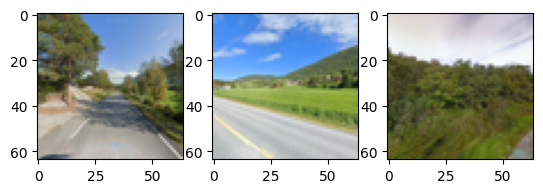

In [4]:
fig, axs = plt.subplots(1, 3)

for i, ax in enumerate(axs.ravel()):
  d = train_inputs[i] * std + mean
  ax.imshow(d.int().cpu().detach().numpy().transpose(1, 2, 0))

In [73]:
class ConvModule(nn.Module):
  def __init__(self, in_features, out_features) -> None:
    super(ConvModule, self).__init__()
    self.conv = nn.Conv2d(in_features, out_features, 5, padding=2)
    self.norm = nn.BatchNorm2d(out_features)

  def forward(self, x) -> torch.Tensor:
    x = self.norm(self.conv(x))
    return torch.relu(x)

class NSVDModel(nn.Module):
  def __init__(self) -> None:
    super(NSVDModel, self).__init__()
    self.pool = nn.MaxPool2d(2)
    self.conv1 = ConvModule(3, 64)
    self.conv2 = ConvModule(64, 128)
    self.conv3 = ConvModule(128, 256)
    self.l1 = nn.Linear(256*8*8, 1024)
    self.l2 = nn.Linear(1024, 2)
    
  def forward(self, x):
    x = self.pool(self.conv1(x)) # 64 -> 32
    x = self.pool(self.conv2(x)) # 32 -> 16
    x = self.pool(self.conv3(x)) # 16 -> 8
    x = x.reshape(-1, 256*8*8)
    x = torch.relu(self.l1(x))
    x = self.l2(x)
    return x


' \n\n    self.stack = nn.Sequential(\n      ConvModule(3, 32), # 64 -> 32\n      ConvModule(32, 64), # 32 -> 16\n      ConvModule(64, 64), # 16 -> 8\n      nn.Flatten(),\n      nn.Linear(64*8*8, 512),\n      nn.ReLU(),\n      nn.Linear(512, 2)\n      #nn.Linear(64*16*16, 2),\n    )\n      nn.Conv2d(3, 32, 5, padding=2),\n      nn.BatchNorm2d(32),\n      nn.ReLU(),\n      nn.MaxPool2d(2), # 64 -> 32\n\n      nn.Conv2d(32, 64, 5, padding=2),\n      nn.BatchNorm2d(64),\n      nn.ReLU(),\n      nn.MaxPool2d(2), # 32 -> 16\n\n      nn.Conv2d(64, 64, 5, padding=2),\n      nn.BatchNorm2d(64),\n      nn.ReLU(),\n      nn.MaxPool2d(2), # 16 -> 7\n\n      nn.Flatten(),\n      nn.Linear(64*7*7, 512),\n      nn.ReLU(),\n      nn.Linear(512, 2)\n      '

In [74]:
model = NSVDModel()
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
  epoch_loss = 0
  for batch in range(len(train_input_batches)):
    y = model(train_input_batches[batch])
    loss = loss_fn(y, train_target_batches[batch])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss
  print("epoch: {}; loss: {}".format(epoch, epoch_loss/len(train_input_batches)))
  

epoch: 0; loss: 70.74248504638672
epoch: 1; loss: 25.69341278076172
epoch: 2; loss: 25.65464973449707
epoch: 3; loss: 25.01890754699707
epoch: 4; loss: 24.013221740722656
epoch: 5; loss: 22.852935791015625
epoch: 6; loss: 21.6688175201416
epoch: 7; loss: 20.951162338256836
epoch: 8; loss: 20.227548599243164
epoch: 9; loss: 19.76840591430664
epoch: 10; loss: 19.601091384887695
epoch: 11; loss: 19.605602264404297
epoch: 12; loss: 20.16520881652832
epoch: 13; loss: 18.583202362060547
epoch: 14; loss: 17.832216262817383
epoch: 15; loss: 17.20201301574707
epoch: 16; loss: 16.91265869140625
epoch: 17; loss: 16.293434143066406
epoch: 18; loss: 15.817723274230957
epoch: 19; loss: 15.268024444580078
epoch: 20; loss: 14.803975105285645
epoch: 21; loss: 14.264421463012695
epoch: 22; loss: 13.25025463104248
epoch: 23; loss: 12.391411781311035
epoch: 24; loss: 11.901264190673828
epoch: 25; loss: 11.664467811584473
epoch: 26; loss: 13.075671195983887
epoch: 27; loss: 17.204208374023438
epoch: 28; lo

In [62]:
torch.save(model, './data/model')

In [94]:
test_images = [{'file':'9w8nB2zvVz', 'loc':[69.1326326,23.3151797]}]
test_im = np.random.choice(test_images, 1)[0]
test_im

{'file': '9w8nB2zvVz', 'loc': [69.1326326, 23.3151797]}

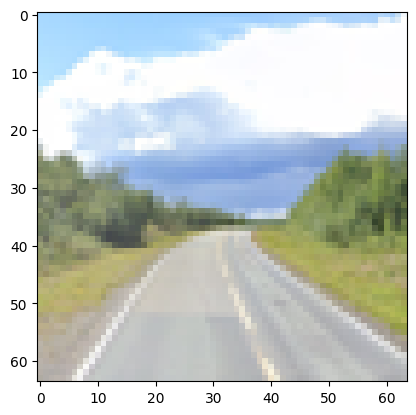

In [95]:
from PIL import Image

im = Image.open('./data/test_images/{}.png'.format(test_im['file'])).convert('RGB')
w, h = im.size
left = int((w - 512)/2)
top = int((h - 512)/2)
right = int((w + 512)/2)
bottom = int((h + 512)/2)

im = im.crop((left, top, right, bottom)).resize((64, 64))
im_data = torch.tensor(np.asarray(im).transpose(2, 0, 1))

plt.imshow(im_data.int().numpy().transpose(1, 2, 0))

In [96]:
im_data = im_data.to(device)
im_data = (im_data - mean) / std

y = model(im_data.unsqueeze(0)).flatten()
guessed_loc = (y[0].item(), y[1].item())
print(guessed_loc)

(73.0811538696289, 15.114006996154785)


In [97]:
import folium

real_loc = test_im['loc']

m = folium.Map((64.9701, 13.509217), zoom_start=4)
folium.CircleMarker(location=(real_loc[0], real_loc[1]), tooltip='real', radius=1, color='#0080bb', fill_color='#0080bb').add_to(m)
folium.CircleMarker(location=(guessed_loc[0], guessed_loc[1]), tooltip='guessed', radius=1, color='#d40834', fill_color='#d40834').add_to(m)
m
